# Predicting Coffee Degredation with Taste Notes


#### Background

#### Methods

#### Ideology

...

#### Data Background

**Taste Notes** (originally 'Comments'): "Notes taken during cupping." <br>
**Score**: "Single Sample level score comprised of mean of present cuppers." <br>
**PSS**: "Score of pre-shipment sample if applies to a given coffee."


In [102]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from difflib import SequenceMatcher

# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# NLP
from sklearn.feature_extraction.text import TfidfVectorizer

#### Import Data

In [103]:
# read xlsx and convert to DataFrame
original_data = pd.read_excel("data/2018_2019_2020_DataSheet.xlsx")

# select relevant columns
shaped_df = original_data[['Comments', 'Score', 'PSS ']]

# rename as needed
shaped_df = shaped_df.rename(columns={'PSS ': 'PSS', 'Comments': 'Taste Notes'})

# remove rows with missing values
shaped_df = shaped_df.dropna()

# check the data type of 'Score' and 'PSS' columns and keep only rows with numeric values
shaped_df = shaped_df[pd.to_numeric(shaped_df['Score'], errors='coerce').notnull()]
shaped_df = shaped_df[pd.to_numeric(shaped_df['PSS'], errors='coerce').notnull()]

# create new column for change in Quality Score ('Delta')
shaped_df['Delta'] = shaped_df['Score'] - shaped_df['PSS']

# display dataframe
shaped_df.shape

(3908, 4)

#### Visualising the Shaped Data

To enhance the clarity of our visualization, we will focus on the central 99% of the data, excluding any outliers that may be present due to potential data entry or testing errors.

Average Change in Coffee Quality: -2.0641946771507
Standard Deviation of Coffee Quality Change: 2.628896184887818


/Users/michaelsaccio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


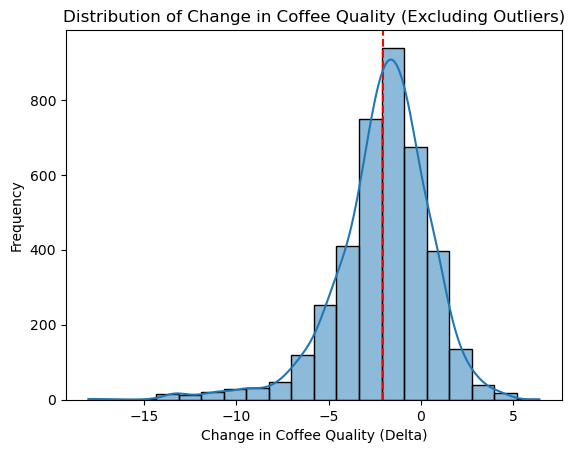

In [104]:
# adjusting for data entry errors
# remove rows with 'Delta' values less than -18 or higher than 18
shaped_df = shaped_df[(shaped_df['Delta'] >= -18) & (shaped_df['Delta'] <= 18)]

# sample statistics
# print average change and standard deviation in coffee quality
mean_delta = np.mean(shaped_df['Delta'])
std_delta = np.std(shaped_df['Delta'])
print("Average Change in Coffee Quality:", mean_delta)
print("Standard Deviation of Coffee Quality Change:", std_delta)

# add a vertical line for the mean
plt.axvline(mean_delta, color='red', linestyle='dashed', linewidth=1.5)

# create a histogram of the filtered 'Delta' column
sns.histplot(data=shaped_df, x='Delta', bins=20, kde=True)
plt.xlabel('Change in Coffee Quality (Delta)')
plt.ylabel('Frequency')
plt.title('Distribution of Change in Coffee Quality (Excluding Outliers)')
plt.show()

#### Data Cleaning

In [105]:
# convert 'Taste Notes' to lowercase
shaped_df['Taste Notes'] = shaped_df['Taste Notes'].str.lower()

# remove special characters (besides commas)
shaped_df['Taste Notes'] = shaped_df['Taste Notes'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s,]', '', x))

# remove taste notes containing numbers
shaped_df['Taste Notes'] = shaped_df['Taste Notes'].apply(lambda x: ', '.join([word for word in x.split(', ') if not any(char.isdigit() for char in word)]))

# create a copy to use for NLP
nlp_shaped_df = shaped_df.copy()

# preview the 'Taste Notes' Column
shaped_df['Taste Notes'].head(10)

0     soft, tart citric acid, carrot, toffee, lemon,...
1     juicy, burnt sugar, citrus, apple, grape, tang...
2     muddled, slight age paper flavor, strong citri...
5     toffee, lemon, some pith, carrot, bitter, tart...
6     chocolate, good citric acid, dark chocolate, a...
7       savory vegetal, heavy, tart citric acid, bitter
8     mint, soft and mellow, bitter herb, vegetal, p...
10    cocoa, dirty herb, muddled, earthy, more bitte...
11    nut brittle, toffee, tart citric, vegetal cool...
13    chocolate, toffee, good citric acid, good swee...
Name: Taste Notes, dtype: object

Let's take a better look at our Taste Notes by grouping, sorting, and then exporting them to Excel

In [11]:
# split the 'Taste Notes' column into individual taste notes
taste_notes_split = shaped_df['Taste Notes'].str.split(', ')

# loop through the split taste notes and add them to a list
all_taste_notes = []
for notes in taste_notes_split:
    all_taste_notes.extend(notes)

# create a DataFrame to store taste notes and their counts
taste_notes_df = pd.DataFrame({'Taste Notes': all_taste_notes})

# count the occurrences of each taste note
taste_notes_counts = taste_notes_df['Taste Notes'].value_counts().reset_index()

# rename the columns for clarity
taste_notes_counts.columns = ['Taste Note', 'Count']

# sort the taste notes by count in descending order
taste_notes_counts = taste_notes_counts.sort_values(by='Count', ascending=False)

# export as xlsx file
### taste_notes_counts.to_excel("data/grouped_taste_notes.xlsx", index=False)
### print('The data has been exported')

Using insights gained from the Excel sheet, we can make necessary changes to refine the 'Taste Notes' column

In [12]:
# select only the top 100 notes
top_100_taste_notes = taste_notes_counts.head(100).copy()

# remove empty cells (cells with only whitespace) from the copy
top_100_taste_notes['Taste Note'] = top_100_taste_notes['Taste Note'].replace(r'^\s*$', '', regex=True)

# replace 'at' with 'aftertaste' in the copy
top_100_taste_notes['Taste Note'] = top_100_taste_notes['Taste Note'].str.replace(r'\bat\b', 'aftertaste', regex=True)

# replace 'mf' with 'mouthfeel' in the copy
top_100_taste_notes['Taste Note'] = top_100_taste_notes['Taste Note'].str.replace(r'\bmf\b', 'mouthfeel', regex=True)

# replace 'frt' with 'fruit' in the copy
top_100_taste_notes['Taste Note'] = top_100_taste_notes['Taste Note'].str.replace(r'\bfrt\b', 'fruit', regex=True)

# export as xlsx file
### top_100_taste_notes.to_excel("data/top_100_taste_notes.xlsx", index=False)
### print('The data has been exported')

### Feature Reduction (Higher Bias, Lower Variance)

At this point, we still have far too many taste notes, with many mispellings and different forms of the same word. It would be too much of a hastle to manually fix all of these notes for this and future data sets, so instead, we will only take some. 

For this model, we will take the top 100 notes plus the notes not already used in the 'Coffee Wheel' and categorize them.

In [13]:
# import the manually sorted and cleaned taste notes groups dataframe
categorized_notes = pd.read_excel("data/taste notes grouping.xlsx")

# remove the 'Count' column
categorized_notes = categorized_notes.drop(columns=['Count'])

# rename category column 
categorized_notes.rename(columns={'Major Group': 'Category'})

# print shape information
print(f"Taste Notes with assigned Categories: {len(categorized_notes)}")
print(f"Number of Unique Categories: {categorized_notes['Major Group'].nunique()}")

# display the unique categories
unique_major_groups = categorized_notes['Major Group'].unique().tolist()
print(unique_major_groups)

Taste Notes with assigned Categories: 174
Number of Unique Categories: 26
['abs', 'balanced', 'cara', 'chemical', 'citrus fruit', 'clean', 'creamy', 'dry', 'flat', 'floral', 'fruity', 'gf', 'green/vegetative', 'heavy', 'juicy', 'mild', 'nutty/cocoa', 'papery/musty', 'rich', 'roasted', 'savory', 'soft', 'sour/fermented', 'spices', 'sweet', 'tangy']


In [14]:
# remove any empty spots by replacing ",," with ","
shaped_df['Taste Notes'] = shaped_df['Taste Notes'].str.replace(r',,', ',', regex=True)
shaped_df['Taste Notes'] = shaped_df['Taste Notes'].str.replace(r',\s*,', ',', regex=True)
shaped_df

,Taste Notes,Score,PSS,Delta
0,"soft, tart citric acid, carrot, toffee, lemon,...",84.500000,87.5,-3.0
1,"juicy, burnt sugar, citrus, apple, grape, tang...",88.000000,87.67,0.33
2,"muddled, slight age paper flavor, strong citri...",81.666667,87,-5.333333
5,"toffee, lemon, some pith, carrot, bitter, tart...",84.833333,86.25,-1.416667
6,"chocolate, good citric acid, dark chocolate, a...",84.000000,87,-3.0
...,...,...,...,...
18033,"process, herbaceous, chemical,",79.000000,79.75,-0.75
18039,"dark chocolate, coffee cherry, herbaceous",84.500000,87.5,-3.0
18043,"process, eraser,",78.000000,79.75,-1.75
18045,"tart, dry, chocolate, citrus peel, coffee cherry",84.500000,87.33,-2.83


### Feature Reduction Strategy

In this code block, I've implemented a feature reduction strategy that aims to categorize the diverse taste notes into a more concise set of "Taste Categories." This approach involves checking the similarity of each taste note with a predefined set of notes in a separate spreadsheet. The most similar note from the spreadsheet is then assigned, and each row in the dataset is associated with one or more taste categories based on this similarity. An interesting aspect of this strategy is its adaptability. To improve categorization accuracy, an easy enhancement is to manually add more taste notes into the predefined category spreadsheet. This allows the model to learn from a broader range of taste descriptors, enhancing its ability to categorize diverse notes accurately. It's worth noting that I designed and implemented this strategy as a low-variance approach, effectively reducing feature quantity from potentially thousands of unique taste notes to only a couple dozen categories. This reduction streamlines the dataset by lowering its complexity, making it more manageable for analysis and interpretation.


#### Methodology

The following steps outline the feature reduction strategy:

1.&nbsp;**Similarity Calculation:**
   - A function, `get_similarity`, is defined to calculate the similarity between two strings using the SequenceMatchers ratio method.

2.&nbsp;**Minimum Similarity Threshold:**
   - A minimum similarity threshold (`similarity_threshold`) is set to control the assignment of taste notes to categories. Only notes with a similarity score above this threshold are considered for category assignment.

3.&nbsp;**Taste Categories Column Creation:**
   - A new column, 'Taste Categories,' is created in the DataFrame (`shaped_df`) to store the assigned categories.

4.&nbsp;**Iterating Through Each Row:**
   - For each row in the DataFrame, the taste notes are extracted and split into individual notes.

5.&nbsp;**Finding the Best Category:**
   - Iterating through each taste note, the algorithm searches for the most similar note in the predefined spreadsheet (`categorized_notes`). The category of the most similar note is assigned to the current taste note.

6.&nbsp;**Category Assignment:**
   - If the similarity score is above the set threshold, the assigned category is added to a list for that row.

7.&nbsp;**Handling No Close Match:**
   - If no close match is found for any of the taste notes, the category "Other" is assigned.

8.&nbsp;**Combining Categories:**
   - The assigned categories for all taste notes in a row are combined into a single string.

9.&nbsp;**Filtering Rows:**
   - Rows with no assigned category other than "Other" are removed from the DataFrame.

10.&nbsp;**Column Reordering:**
    - The columns are reordered to move the 'Taste Categories' column after 'Taste Notes.'


In [15]:
# function to calculate similarity between two strings
def get_similarity(string1, string2):
    return SequenceMatcher(None, string1, string2).ratio()

# set a minimum similarity threshold
similarity_threshold = 0.7

# create a new column 'Taste Categories' in the DataFrame
shaped_df['Taste Categories'] = ""

# iterate through each row in the DataFrame
for index, row in shaped_df.iterrows():
    # get the current taste notes
    taste_notes = row['Taste Notes'].split(', ')
    
    # initialize a list to store the categories for each note
    categories = []
    
    # iterate through each taste note in the row
    for taste_note in taste_notes:
        # initialize variables to track the best category and similarity
        best_category = ""
        max_similarity = 0.0
        
        # iterate through categorized notes to find the best category for the current note
        for cat_index, cat_row in categorized_notes.iterrows():
            category = cat_row['Major Group']
            
            # calculate similarity
            similarity = get_similarity(taste_note, cat_row['Taste Note'])
            
            # update the best category if similarity is higher
            if similarity > max_similarity:
                max_similarity = similarity
                best_category = category
        
        # assign the best category if the similarity is above the threshold
        if max_similarity >= similarity_threshold:
            categories.append(best_category)
    
    # assign 'Other' if no close match found for any of the notes
    if not categories:
        categories = ["Other"]
    
    # join the categories for all notes into a single string
    combined_categories = ', '.join(categories)
    
    # assign the combined categories to the 'Taste Categories' column for this row
    shaped_df.at[index, 'Taste Categories'] = combined_categories

# remove rows with no assigned category
shaped_df = shaped_df[shaped_df['Taste Categories'] != 'Other']

# reorder the columns to move 'Taste Categories' after 'Taste Notes'
column_order = ['Taste Notes', 'Taste Categories', 'Score', 'PSS', 'Delta']
shaped_df = shaped_df[column_order]

# display the updated shaped_df
shaped_df

,Taste Notes,Taste Categories,Score,PSS,Delta
0,"soft, tart citric acid, carrot, toffee, lemon,...","soft, sour/fermented, sweet, citrus fruit, flo...",84.500000,87.5,-3.0
1,"juicy, burnt sugar, citrus, apple, grape, tang...","juicy, sweet, citrus fruit, fruity, fruity, ci...",88.000000,87.67,0.33
2,"muddled, slight age paper flavor, strong citri...","sour/fermented, nutty/cocoa, citrus fruit, nut...",81.666667,87,-5.333333
5,"toffee, lemon, some pith, carrot, bitter, tart...","sweet, citrus fruit, sour/fermented, chemical,...",84.833333,86.25,-1.416667
6,"chocolate, good citric acid, dark chocolate, a...","nutty/cocoa, sour/fermented, nutty/cocoa",84.000000,87,-3.0
...,...,...,...,...,...
18030,"coffee cherry pulp, chocolate,","fruity, nutty/cocoa",85.500000,87,-1.5
18033,"process, herbaceous, chemical,","green/vegetative, chemical",79.000000,79.75,-0.75
18039,"dark chocolate, coffee cherry, herbaceous","nutty/cocoa, fruity, green/vegetative",84.500000,87.5,-3.0
18045,"tart, dry, chocolate, citrus peel, coffee cherry","citrus fruit, dry, nutty/cocoa, citrus fruit, ...",84.500000,87.33,-2.83


In [16]:
# list of unique major flavor categories
unique_categories = ['abs', 'balanced', 'cara', 'chemical', 'citrus fruit', 'clean', 'creamy', 'dry', 'flat', 'floral',
                     'fruity', 'gf', 'green/vegetative', 'heavy', 'juicy', 'mild', 'nutty/cocoa', 'papery/musty', 
                     'rich', 'roasted', 'savory', 'soft', 'sour/fermented', 'spices', 'sweet', 'tangy']

# iterate through each unique category and one-hot encode it
for category in unique_categories:
    shaped_df[category] = shaped_df['Taste Categories'].apply(lambda x: 1 if category in x.split(', ') else 0)

# drop the 'Taste Categories' column since it's no longer needed
shaped_df = shaped_df.drop(columns=['Taste Categories'])

shaped_df.head()

,Taste Notes,Score,PSS,Delta,abs,balanced,cara,chemical,citrus fruit,clean,...,nutty/cocoa,papery/musty,rich,roasted,savory,soft,sour/fermented,spices,sweet,tangy
0,"soft, tart citric acid, carrot, toffee, lemon,...",84.500000,87.5,-3.0,0,0,0,0,1,0,...,1,0,0,0,0,1,1,0,1,0
1,"juicy, burnt sugar, citrus, apple, grape, tang...",88.000000,87.67,0.33,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,"muddled, slight age paper flavor, strong citri...",81.666667,87,-5.333333,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
5,"toffee, lemon, some pith, carrot, bitter, tart...",84.833333,86.25,-1.416667,0,0,0,1,1,0,...,1,0,0,0,0,0,1,0,1,0
6,"chocolate, good citric acid, dark chocolate, a...",84.000000,87,-3.0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


#### Calculating Correlation with Quality Change

In this section, the code computes the correlation matrix to explore the relationships between various features and the change in coffee quality ('Delta'). The primary focus is on taste notes categories and their influence on quality reduction. A negative correlation signifies an inverse relationship between the taste note category and the change in coffee quality. In other words, a very low value, on average, is associated with more degradation in coffee quality.

In [17]:
# calculate the correlation matrix
correlation_df = shaped_df[['Delta'] + list(shaped_df.columns[5:])]
correlation_matrix = correlation_df.corr()

# extract the correlations between 'Delta' and taste notes
delta_correlations = correlation_matrix['Delta']

# sort the taste notes by their negative correlation values (i.e., impact on reducing quality)
sorted_correlations = delta_correlations.sort_values(ascending=True)

# print the taste notes and their correlations with 'Delta'
print(sorted_correlations)

papery/musty       -0.277884
chemical           -0.240716
green/vegetative   -0.169368
roasted            -0.143683
nutty/cocoa        -0.113199
dry                -0.111751
flat               -0.076714
mild               -0.056018
spices             -0.019355
sour/fermented     -0.018811
savory             -0.006771
gf                  0.012000
tangy               0.013992
clean               0.038829
cara                0.043645
heavy               0.044239
balanced            0.045900
sweet               0.060787
floral              0.061663
rich                0.063445
soft                0.072197
citrus fruit        0.080312
creamy              0.084814
juicy               0.123285
fruity              0.163688
Delta               1.000000
Name: Delta, dtype: float64


#### Machine Learning model for Feature Reduction

This section introduces a simple linear regression model integrated into the feature reduction methodology. The model's purpose is to predict the change in coffee quality ('Delta') based on carefully selected features. It acts as an initial tool for gauging the predictive capabilities of these features in estimating changes in coffee quality. While more sophisticated models, as seen later on, could be implemented, this feature reduction section primarily serves as a demonstration of methodology rather than a finalized prediction strategy. The evaluation metrics, including Mean Squared Error and R-squared, offer insights into the accuracy of the model and the effectiveness of the chosen features in predicting quality changes.

In [18]:
# define features (X) and target variable (y)
X = shaped_df.drop(columns=['Score', 'PSS', 'Delta', 'Taste Notes'])
y = shaped_df['Delta']

# split the data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# initialize the linear regression model
model = LinearRegression()

# train the model
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 5.5525526032508585
R-squared: 0.1875642737190546


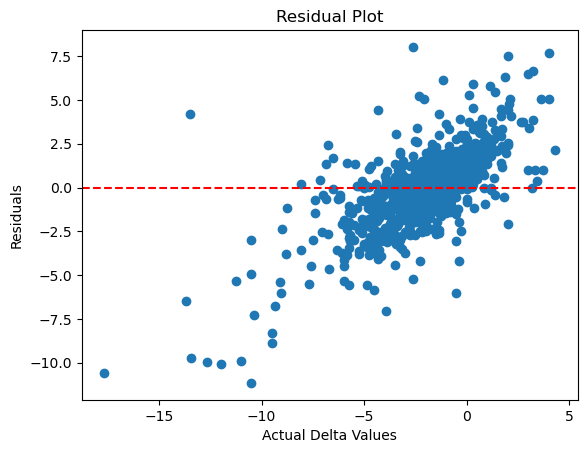

In [152]:
# residual plot
residuals = y_test - y_pred
plt.scatter(y_test, residuals)
plt.xlabel("Actual Delta Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

### Natural Language Processing (NLP) of Taste Notes (Lower Bias, Higher Variance)

In [106]:
# dataframe copied previously
nlp_shaped_df

,Taste Notes,Score,PSS,Delta
0,"soft, tart citric acid, carrot, toffee, lemon,...",84.500000,87.5,-3.0
1,"juicy, burnt sugar, citrus, apple, grape, tang...",88.000000,87.67,0.33
2,"muddled, slight age paper flavor, strong citri...",81.666667,87,-5.333333
5,"toffee, lemon, some pith, carrot, bitter, tart...",84.833333,86.25,-1.416667
6,"chocolate, good citric acid, dark chocolate, a...",84.000000,87,-3.0
...,...,...,...,...
18033,"process, herbaceous, chemical,",79.000000,79.75,-0.75
18039,"dark chocolate, coffee cherry, herbaceous",84.500000,87.5,-3.0
18043,"process, eraser,",78.000000,79.75,-1.75
18045,"tart, dry, chocolate, citrus peel, coffee cherry",84.500000,87.33,-2.83


#### Basic Linear Regression Machine Learning Usage

In contrast to more conventional Natural Language Processing methods employed by large language models, we opt for the TfidfVectorizer to convert text data into numerical features. This approach is chosen for its simplicity in model implementation and ease of use, making it a practical choice for our linear regression model. The TfidfVectorizer transforms textual information into a format that is more readily interpretable by the model, facilitating a straightforward integration of machine learning techniques into the analysis.

In [107]:
# data preprocessing (Bag of Words)
X = nlp_shaped_df['Taste Notes'].str.replace(', ', ' ')
y = nlp_shaped_df['Delta']

# feature extraction and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

model = LinearRegression()
model.fit(X_train_transformed, y_train)

# model evaluation
y_pred = model.predict(X_test_transformed)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 5.369896023149296


#### Find the Optimal Number of Taste Notes to use in Model Creation

This section employs the run_model_with_taste_notes function to explore the impact of varying numbers of taste notes on the linear regression model's performance. The function, taking a DataFrame (`df`) and the desired number of taste notes (`num_taste_notes`) as input, tests 12 different models with unique selections of taste notes. The best-performing model, determined by the lowest Mean Squared Error, is assigned to `best_num_taste_notes`. 

This iterative process provides valuable insights into the optimal number of taste notes that result in the lowest MSE, aiding in a more informed selection of features for the linear regression model.

In [108]:
def run_model_with_taste_notes(df, num_taste_notes):
    # data preprocessing (selecting first 'num_taste_notes' before removing commas)
    df['Selected_Taste_Notes'] = df['Taste Notes'].apply(lambda x: ', '.join(x.split(', ')[:num_taste_notes]))

    X = df['Selected_Taste_Notes']
    y = df['Delta']

    # feature extraction and model training
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    vectorizer = TfidfVectorizer()
    X_train_transformed = vectorizer.fit_transform(X_train)
    X_test_transformed = vectorizer.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_transformed, y_train)

    # model evaluation
    y_pred = model.predict(X_test_transformed)
    mse = mean_squared_error(y_test, y_pred)

    return mse

# example usage to find the lowest MSE
lowest_mse = float('inf')
best_num_taste_notes = None

for num_taste_notes in range(1, 13):
    mse = run_model_with_taste_notes(nlp_shaped_df, num_taste_notes)
    print(f'Mean Squared Error with {num_taste_notes} taste notes: {mse}')

    if mse < lowest_mse:
        lowest_mse = mse
        best_num_taste_notes = num_taste_notes

print(f"\nLowest Mean Squared Error is {lowest_mse} with {best_num_taste_notes} taste notes.")

Mean Squared Error with 1 taste notes: 5.850863180184298
Mean Squared Error with 2 taste notes: 5.542320195740591
Mean Squared Error with 3 taste notes: 5.304839722613788
Mean Squared Error with 4 taste notes: 5.112187244195165
Mean Squared Error with 5 taste notes: 5.224865873506158
Mean Squared Error with 6 taste notes: 5.080180642375054
Mean Squared Error with 7 taste notes: 5.27567064831246
Mean Squared Error with 8 taste notes: 5.520182025017158
Mean Squared Error with 9 taste notes: 5.068721567534327
Mean Squared Error with 10 taste notes: 5.09181789515973
Mean Squared Error with 11 taste notes: 5.157249027510462
Mean Squared Error with 12 taste notes: 5.290478181261262

Lowest Mean Squared Error is 5.068721567534327 with 9 taste notes.


### Implementing a Random Forest Regression Model

In this section, we take a step further by implementing a Random Forest Regression model, utilizing the `best_num_taste_notes` value for optimal taste note selection. The Random Forest model offers a distinct advantage with its tunable hyperparameters, providing an avenue for fine-tuning its performance, especially when dealing with significant changes in the training data.

This implementation allows us to harness the flexibility of the Random Forest model and optimize its parameters to achieve improved predictive performance. The evaluated MSE provides insights into the accuracy of the model's predictions with the selected features.

In [122]:
# data preprocessing (selecting first x taste notes before removing commas)
nlp_shaped_df['First_Four_Taste_Notes'] = nlp_shaped_df['Taste Notes'].apply(lambda x: ', '.join(x.split(', ')[:best_num_taste_notes]))

X = nlp_shaped_df['First_Four_Taste_Notes']
y = nlp_shaped_df['Delta']

# feature extraction and model training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)
X_test_transformed = vectorizer.transform(X_test)

# random forest regressor with hyperparameter tuning
param_grid = {'n_estimators': [50, 100, 150],
              'max_depth': [None, 10, 20],
              'min_samples_split': [2, 5, 10]}

rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_transformed, y_train)

best_rf_model = grid_search.best_estimator_

# model evaluation
y_pred_rf = best_rf_model.predict(X_test_transformed)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Mean Squared Error with Random Forest: {mse_rf}')

Mean Squared Error with Random Forest: 4.727343898926569


### Results

The analysis utilized a dataset of coffee samples, split into training and testing sets for model evaluation. The Random Forest model was employed to assess prediction errors, comparing its performance against a mean delta approach. Evaluation metrics, including R-squared, provided insights into the model's ability to capture variance. A paired t-test with a substantial number of errors underscored the statistical significance of the model comparison. Error distribution visualization through a histogram emphasized the model's effectiveness in reducing prediction errors, reinforcing its superiority over a simplistic mean delta strategy.

Number of Coffee Samples: 3888
Average Prediction Error (Random Forest): 1.555
Average Error using Mean Delta: 1.917
Percentage Improvement over Mean Delta: 18.91%

R-Squared (Random Forest): 0.286
Percentage of Unexplained Variance: 71.393%

Number of Errors used for T-test: 778
p-value: 0.00016979530156127463
Reject the null hypothesis. The Random Forest model performs significantly better than using only the mean delta value.


/Users/michaelsaccio/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


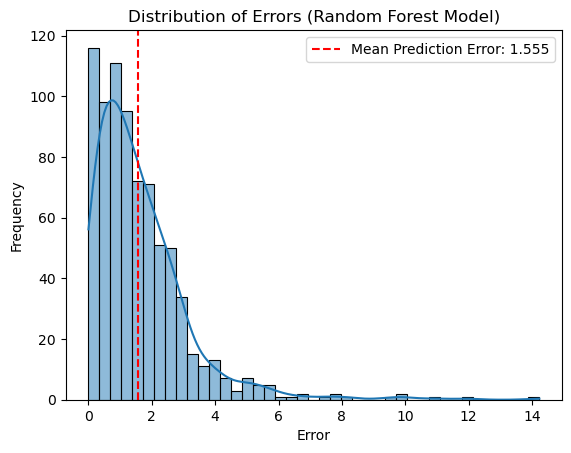

In [161]:
# print the number of data points (coffee samples) used in training and testing
print(f'Number of Coffee Samples: {len(nlp_shaped_df)}')

# calculate and print the average error using the Random Forest model
average_prediction_error_rf = abs(y_test - y_pred_rf).mean()
print(f'Average Prediction Error (Random Forest): {average_prediction_error_rf:.3f}')

# calculate and print the average error using the mean delta
average_error_mean_delta = abs(mean_delta - nlp_shaped_df['Delta']).mean()
print(f'Average Error using Mean Delta: {average_error_mean_delta:.3f}')

# calculate the relative improvement in MSE
relative_improvement = (average_error_mean_delta - average_prediction_error_rf) / average_error_mean_delta
print(f'Percentage Improvement over Mean Delta: {relative_improvement*100:.2f}%')

# add the error and percentage error to the DataFrame
results_df['Error'] = abs(results_df['True Delta'] - results_df['Predicted Delta (Random Forest)'])
results_df['Percentage Error'] = percentage_error

# Model Evaluation Metrics
r_squared_rf = r2_score(y_test, y_pred_rf)
print(f'\nR-Squared (Random Forest): {r_squared_rf:.3f}')
print(f'Percentage of Unexplained Variance: {(1-r_squared_rf)*100:.3f}%')

# using random sampling to pull len(y_test) number of mean values
random_sample_mean_delta = np.random.choice(abs(mean_delta - nlp_shaped_df['Delta']), size=len(y_test), replace=False)

# perform a paired t-test
statistic, p_value = ttest_rel(abs(y_test - y_pred_rf), random_sample_mean_delta)

# compare p-value with significance level
alpha = 0.05
print(f'\nNumber of Errors used for T-test: {len(y_test)}')
print(f'p-value: {p_value}')

if p_value < alpha:
    print('Reject the null hypothesis. The Random Forest model performs significantly better than using only the mean delta value.')
else:
    print('Fail to reject the null hypothesis. There is no significant difference between the models.')

# plot distribution of errors for Random Forest model
sns.histplot(results_df['Error'], kde=True)
plt.axvline(x=average_prediction_error_rf, color='red', linestyle='--', label=f'Mean Prediction Error: {average_prediction_error_rf:.3f}')
plt.title('Distribution of Errors (Random Forest Model)')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### Making Predictions

Use this section to make coffee degredation predictions using your own taste notes.

In [ ]:
def predict_coffee_degradation(new_taste_notes):
    # preprocess the new taste notes (use the best_num_taste_notes determined earlier)
    preprocessed_notes = ', '.join(new_taste_notes.split(', ')[:best_num_taste_notes])

    # vectorize the preprocessed notes using the same TF-IDF vectorizer
    preprocessed_transformed = vectorizer.transform([preprocessed_notes])

    # use the trained Random Forest model to make predictions
    predicted_delta = best_rf_model.predict(preprocessed_transformed)[0]

    print(f'Predicted Delta for new taste notes: {predicted_delta}')

# example usage: "citrus, chocolate, nutty"
new_taste_notes_input = "citrus, chocolate, nutty"
predict_coffee_degradation(new_taste_notes_input)